# Fusion Strategies for Multisource Geospatial Data: Comparing MKL, Tabular, and Deep Learning Models​

- Tabular ML
- CNN
- MKL

# 1. Tabular ML

## 1.1 Resampling the nicfi to match the resolution of sentinel-2

### 1.1.1 DownScaling and helper function with the average method

In [10]:
# 

import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling

def downscaling(input_tif, output_tif, matching_tif, bounds_tolerance=1e-4):
    """
    Downscale an input GeoTIFF to match the resolution and dimensions of another GeoTIFF, 
    preserving geospatial alignment, and save the result to an output GeoTIFF.
    
    Args:
        input_tif (str): Path to the input GeoTIFF file to be downscaled.
        output_tif (str): Path where the downscaled GeoTIFF will be saved.
        matching_tif (str): Path to the reference GeoTIFF file whose resolution and size will be matched.
        bounds_tolerance (float): Maximum allowed difference in bounds coordinates (in degrees).
    """
    # Open the reference (matching) GeoTIFF
    with rasterio.open(matching_tif) as match_src:
        # Extract target height, width, transform, and CRS from the reference
        target_height = match_src.height
        target_width = match_src.width
        target_transform = match_src.transform
        target_crs = match_src.crs

    # Open the input GeoTIFF
    with rasterio.open(input_tif) as input_src:
        # Print input shape
        print(f"Input TIF shape: bands={input_src.count}, height={input_src.height}, width={input_src.width}")
        print(f"Target shape: bands={input_src.count}, height={target_height}, width={target_width}")
        
        # Ensure the CRS match
        if input_src.crs != target_crs:
            raise ValueError("CRS mismatch between input_tif and matching_tif.")
        
        # Get both bounds
        input_bounds = input_src.bounds
        target_bounds = rasterio.transform.array_bounds(
            target_height, target_width, target_transform
        )
        
        # Check bounds with tolerance
        bounds_diff = [
            abs(input_bounds.left - target_bounds[0]),
            abs(input_bounds.bottom - target_bounds[1]),
            abs(input_bounds.right - target_bounds[2]),
            abs(input_bounds.top - target_bounds[3])
        ]
        
        if max(bounds_diff) > bounds_tolerance:
            print("Input bounds:", input_bounds)
            print("Target bounds:", target_bounds)
            print("Maximum bounds difference:", max(bounds_diff))
            print("Differences:", bounds_diff)
            raise ValueError(f"Bounds mismatch exceeds tolerance of {bounds_tolerance} degrees.")
        
        # Perform the resampling to match dimensions
        data = input_src.read(
            out_shape=(input_src.count, target_height, target_width),
            resampling=Resampling.average
        )
        
        # Print output shape
        print(f"Output data shape: bands={data.shape[0]}, height={data.shape[1]}, width={data.shape[2]}")
        # print the matching tif 's shape
        print(f"Matching TIF shape: bands={match_src.count}, height={match_src.height}, width={match_src.width}")
        
        
        # Update the output profile to match the reference
        output_profile = input_src.profile.copy()
        output_profile.update({
            'height': target_height,
            'width': target_width,
            'transform': target_transform,
            'crs': target_crs
        })
        
        # Write the resampled data to the output GeoTIFF
        with rasterio.open(output_tif, 'w', **output_profile) as dst:
            dst.write(data)


def procese_all_tifs(input_folder, output_folder, matching_folder):
    # the input folder are the nicfi tif folder
    # the output folder are the downscaled nicfi tif folder
    # the matching folder are the sentinel tif folder which used to be schema for the nicfi
    
    # get the list of tif files in the input folder
    input_tifs = [f for f in os.listdir(input_folder) if f.endswith('.tif')]
    macthed_tifs = [f for f in os.listdir(matching_folder) if f.endswith('.tif')]



    # process each input tif file
    for input_tif in input_tifs:
        input_path = os.path.join(input_folder, input_tif)
        output_path = os.path.join(output_folder, input_tif.replace('.tif', '_rs.tif'))# change the name of file with _rs

        # get the file name of the matching tif file(sentinel [index]-YYYYMMDD-sentinel.tif),but nicfi index-YYYY-MM-nicfi.tif
        match_tif= input_tif.split('-')[0]+"-"+input_tif.split('-')[1]+input_tif.split('-')[2]+'01-sentinel.tif'

        matching_path = os.path.join(matching_folder, match_tif)
        downscaling(input_path, output_path, matching_path)
        print(f"Processing: {input_tif}, Saved target raster to: {output_path},mached target raster to: {matching_path}")
    


def visualize_random_samples(original_nicfi_folder, original_sentinel_folder, downscaled_nicfi_folder, num_samples=20):
    """
    Visualize random samples comparing original NICFI, downscaled NICFI, and Sentinel images in a grid.

    Args:
        original_nicfi_folder (str): Path to the folder containing original NICFI TIFFs.
        original_sentinel_folder (str): Path to the folder containing Sentinel TIFFs.
        downscaled_nicfi_folder (str): Path to the folder containing downscaled NICFI TIFFs.
        num_samples (int): Number of random sample sets to display (default: 20).
    """
    # Get the list of NICFI and Sentinel files
    nicfi_files = sorted([f for f in os.listdir(original_nicfi_folder) if f.endswith('-nicfi.tif')])
    sentinel_files = sorted([f for f in os.listdir(original_sentinel_folder) if f.endswith('-sentinel.tif')])

    # Select random samples
    selected_indices = random.sample(range(len(nicfi_files)), min(num_samples, len(nicfi_files)))

    # Create a grid of 20 sets with 3 images each
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 5 * num_samples))
    fig.suptitle('Comparison of Original NICFI, Downscaled NICFI, and Sentinel Images', fontsize=16)

    # Iterate over selected samples
    for idx, file_idx in enumerate(selected_indices):
        # Extract corresponding files
        original_nicfi_file = nicfi_files[file_idx]
        file_index = original_nicfi_file.split('-')[0]
        
        sentinel_file = next((f for f in sentinel_files if f.split('-')[0] == file_index), None)
        downscaled_nicfi_file = f"{original_nicfi_file.replace('.tif', '_rs.tif')}"

        # Ensure all files exist
        if not sentinel_file or not os.path.exists(os.path.join(downscaled_nicfi_folder, downscaled_nicfi_file)):
            print(f"Skipping sample {file_index}: Missing corresponding files.")
            continue

        original_nicfi_path = os.path.join(original_nicfi_folder, original_nicfi_file)
        sentinel_path = os.path.join(original_sentinel_folder, sentinel_file)
        downscaled_nicfi_path = os.path.join(downscaled_nicfi_folder, downscaled_nicfi_file)

        # Load and visualize the original NICFI image
        with rasterio.open(original_nicfi_path) as src:
            data = src.read(1)
            info = f"Bands={src.count}, Height={src.height}, Width={src.width}"
            axes[idx, 0].imshow(data, cmap='viridis')
            axes[idx, 0].set_title(f"Original NICFI\n{Path(original_nicfi_file).name}", fontsize=10)
            axes[idx, 0].text(0.5, -0.1, info, ha='center', va='top', transform=axes[idx, 0].transAxes, fontsize=8)
            axes[idx, 0].axis('off')

        # Load and visualize the downscaled NICFI image
        with rasterio.open(downscaled_nicfi_path) as src:
            data = src.read(1)
            info = f"Bands={src.count}, Height={src.height}, Width={src.width}"
            axes[idx, 1].imshow(data, cmap='viridis')
            axes[idx, 1].set_title(f"Downscaled NICFI\n{Path(downscaled_nicfi_file).name}", fontsize=10)
            axes[idx, 1].text(0.5, -0.1, info, ha='center', va='top', transform=axes[idx, 1].transAxes, fontsize=8)
            axes[idx, 1].axis('off')

        # Load and visualize the Sentinel image
        with rasterio.open(sentinel_path) as src:
            data = src.read(2) # first band is too small range has bad resulotion 
            info = f"Bands={src.count}, Height={src.height}, Width={src.width}"
            axes[idx, 2].imshow(data, cmap='viridis')
            axes[idx, 2].set_title(f"Sentinel\n{Path(sentinel_file).name}", fontsize=10)
            axes[idx, 2].text(0.5, -0.1, info, ha='center', va='top', transform=axes[idx, 2].transAxes, fontsize=8)
            axes[idx, 2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()


In [6]:

nicif_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_nicfi'
output_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi'
target_folder_path= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel'
procese_all_tifs(nicif_folder_path,output_folder_path,target_folder_path)

Input TIF shape: bands=4, height=42, width=42
Target shape: bands=4, height=22, width=21
Output data shape: bands=4, height=22, width=21
Matching TIF shape: bands=26, height=22, width=21
Processing: 0-2024-03-nicfi.tif, Saved target raster to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi\0-2024-03-nicfi_rs.tif,mached target raster to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel\0-20240301-sentinel.tif
Input TIF shape: bands=4, height=42, width=42
Target shape: bands=4, height=22, width=21
Output data shape: bands=4, height=22, width=21
Matching TIF shape: bands=26, height=22, width=21
Processing: 0-2024-04-nicfi.tif, Saved target raster to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi\0-2024-04-nicfi_rs.tif,mached target raster to: G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_sentinel\0-20240401-sentinel.tif
Input TIF shape: bands=4, height=42, width=42
Target shape: bands=4, height=22, width=21
Output data shape: bands=4,

### 1.1.2 Visualize the results of the resampling

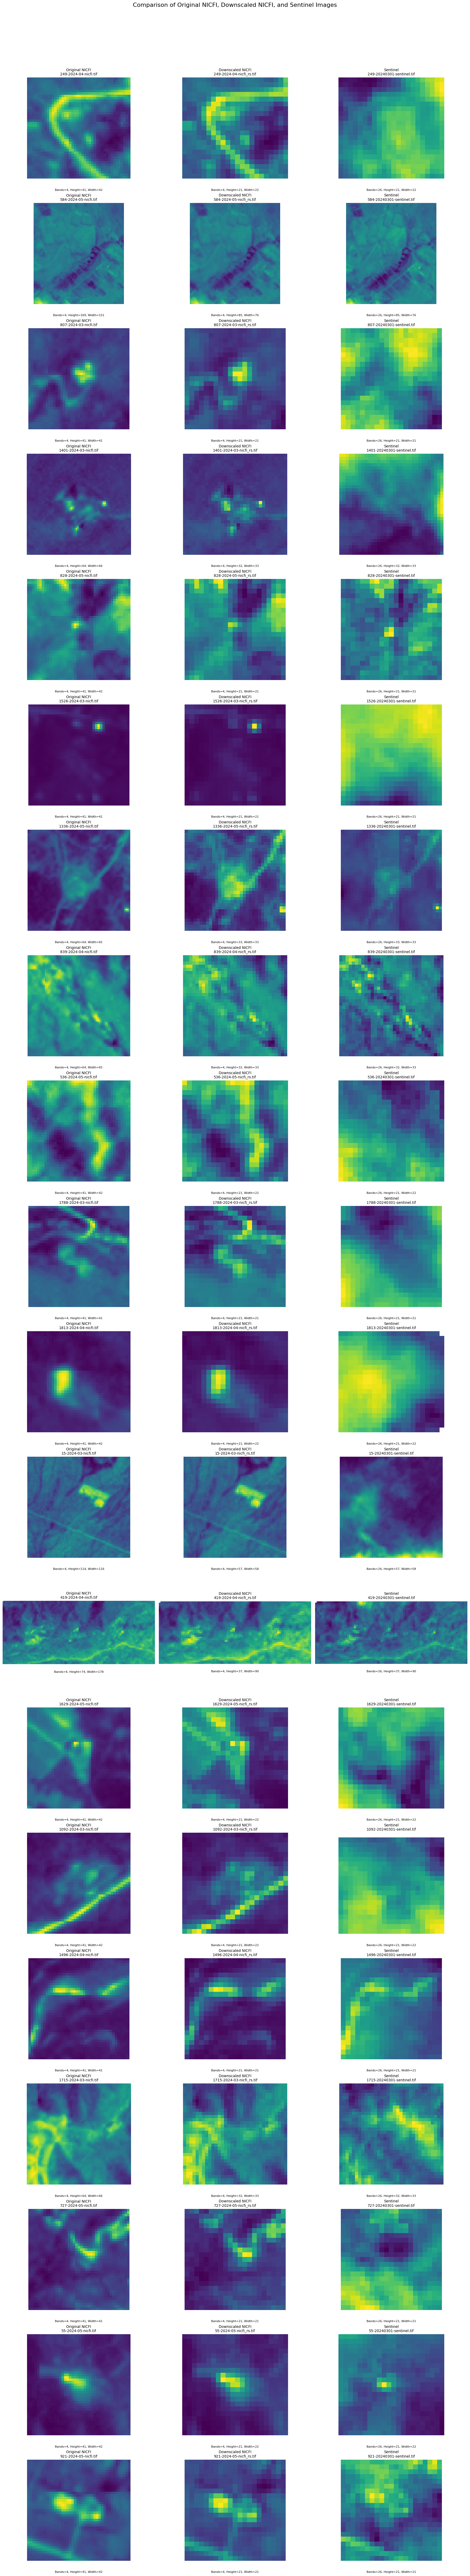

In [11]:
visualize_random_samples(nicif_folder_path, target_folder_path, output_folder_path, num_samples=20)

In [12]:
# count the images in the resampleing tif's folder

resample_nicfi_folder= r'G:\GithubProject\GoogleEarthEngineTask\Tif_ML\dev_downscaled_nicfi'
resample_nicfi_files = sorted([f for f in os.listdir(resample_nicfi_folder) if f.endswith('_rs.tif')])
print(f"Total number of resampleing tif's: {len(resample_nicfi_files)}")

Total number of resampleing tif's: 3636
